
--- Memulai Pelatihan VAE ---
Epoch 1/15 | VAE Average Loss: 279.5263
Epoch 2/15 | VAE Average Loss: 264.5671
Epoch 3/15 | VAE Average Loss: 261.8878
Epoch 4/15 | VAE Average Loss: 260.4641
Epoch 5/15 | VAE Average Loss: 259.2762
Epoch 6/15 | VAE Average Loss: 258.5061
Epoch 7/15 | VAE Average Loss: 257.8450
Epoch 8/15 | VAE Average Loss: 257.3311
Epoch 9/15 | VAE Average Loss: 257.0863
Epoch 10/15 | VAE Average Loss: 256.2668
Epoch 11/15 | VAE Average Loss: 255.7410
Epoch 12/15 | VAE Average Loss: 255.4494
Epoch 13/15 | VAE Average Loss: 255.3337
Epoch 14/15 | VAE Average Loss: 255.2008
Epoch 15/15 | VAE Average Loss: 254.6591

--- Memulai Pelatihan AE ---
Epoch 1/15 | AE Average Loss: 27.6408
Epoch 2/15 | AE Average Loss: 22.8402
Epoch 3/15 | AE Average Loss: 22.0478
Epoch 4/15 | AE Average Loss: 21.5078
Epoch 5/15 | AE Average Loss: 21.0782
Epoch 6/15 | AE Average Loss: 20.7296
Epoch 7/15 | AE Average Loss: 20.4741
Epoch 8/15 | AE Average Loss: 20.2768
Epoch 9/15 | AE Average Loss:

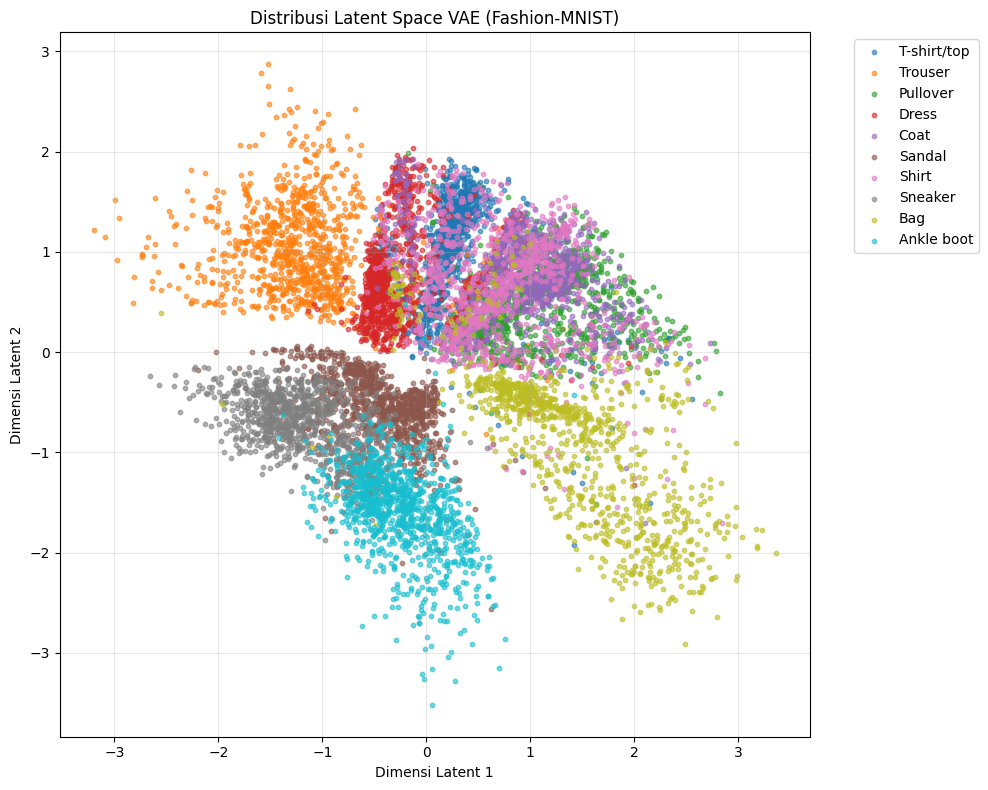


--- Visualisasi Latent Space ---


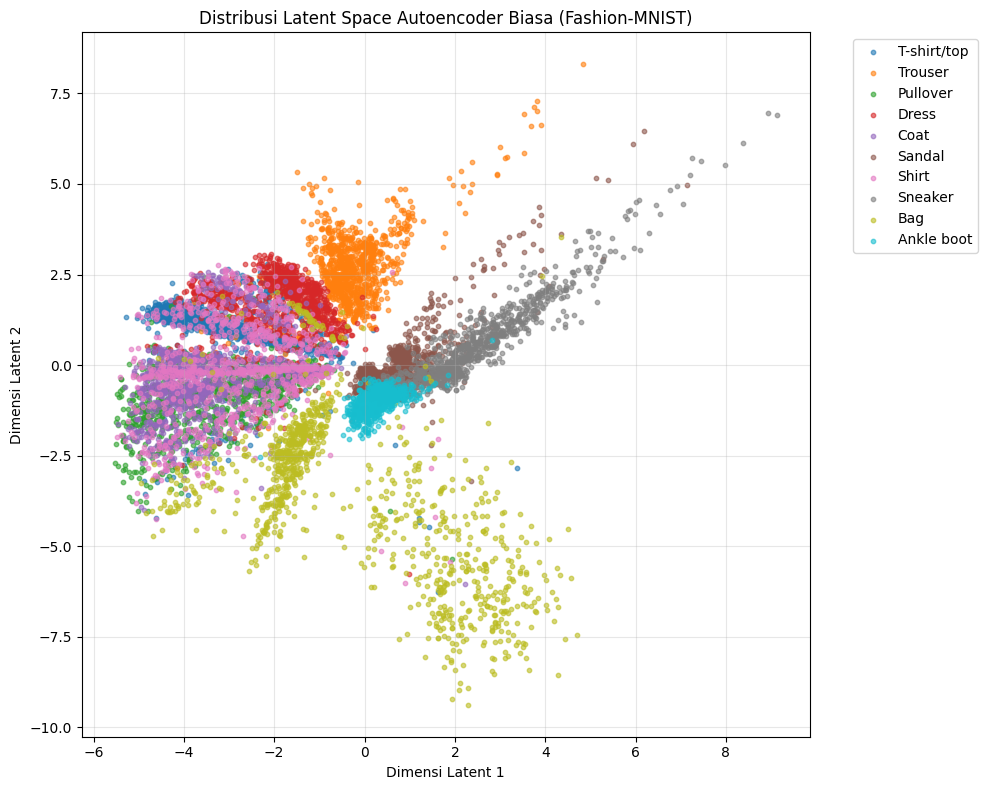


--- Latent Space Arithmetic: Trouser - Pullover + Coat ---


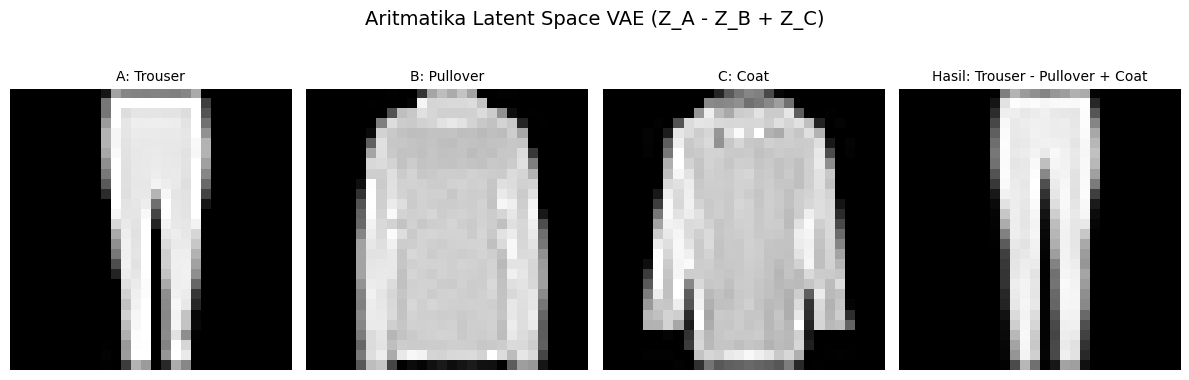


--- Perbandingan Rekonstruksi VAE vs AE ---


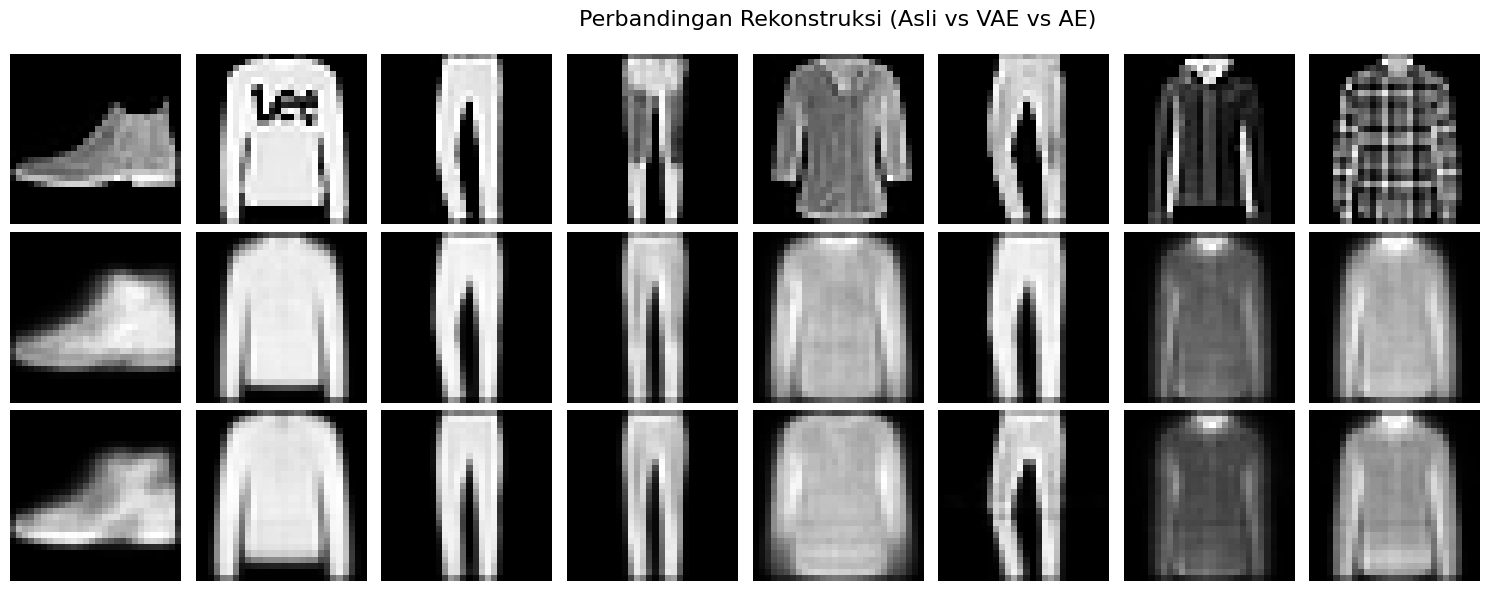


--- Model dan Visualisasi Selesai Dijalankan ---
VAE menggunakan LATENT_DIM=2. Ini memungkinkan visualisasi 2D.
Untuk VAE, perhatikan bahwa latent space cenderung lebih terdistribusi secara halus (smooth) dan mengikuti Gaussian prior (titik lebih padat di tengah), sedangkan AE cenderung mengelompok (clustering) dan mungkin memiliki 'void' di antaranya.
Dalam rekonstruksi, AE mungkin memberikan hasil yang lebih tajam (karena hanya meminimalkan MSE), sedangkan VAE menghasilkan output yang sedikit lebih 'buram' atau halus karena sampling (berusaha untuk menghasilkan data yang bervariasi, bukan hanya salinan terbaik).


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
import os

# --- Konfigurasi dan Hyperparameter ---
# Pastikan Anda memiliki PyTorch, torchvision, numpy, dan matplotlib terinstal.
# Misalnya: pip install torch torchvision numpy matplotlib

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
BATCH_SIZE = 64
LATENT_DIM = 2  # Dimensi 2 agar mudah divisualisasikan
EPOCHS = 15

# --- 1. Definisi Model VAE dan AE ---

class VAE(nn.Module):
    """
    Variational Autoencoder (VAE) Sederhana untuk Fashion-MNIST
    Input: 1x28x28 (Gambar)
    Output: 1x28x28 (Gambar Rekonstruksi)
    Latent Space: 2 (Untuk Visualisasi)
    """
    def __init__(self, latent_dim=LATENT_DIM):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        image_size = 784

        # Encoder
        self.encoder_fc = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU()
        )
        self.fc_mean = nn.Linear(256, latent_dim)
        self.fc_logvar = nn.Linear(256, latent_dim)

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Sigmoid()  # Output harus antara 0 dan 1
        )

    def encode(self, x):
        h = self.encoder_fc(x)
        mean = self.fc_mean(h)
        log_var = self.fc_logvar(h)
        return mean, log_var

    def reparameterize(self, mean, log_var):
        std = torch.exp(0.5 * log_var)
        epsilon = torch.randn_like(std)
        z = mean + epsilon * std
        return z

    def decode(self, z):
        return self.decoder_fc(z).view(-1, 1, 28, 28)

    def forward(self, x):
        # Flatten input 1x28x28 -> 784
        x = x.view(-1, 784)
        mean, log_var = self.encode(x)
        z = self.reparameterize(mean, log_var)
        reconstruction = self.decode(z)
        return reconstruction, mean, log_var, z


class Autoencoder(nn.Module):
    """
    Autoencoder (AE) Biasa Sederhana untuk Fashion-MNIST
    Sama dengan VAE tanpa bagian reparameterisasi (sampling)
    """
    def __init__(self, latent_dim=LATENT_DIM):
        super(Autoencoder, self).__init__()
        self.latent_dim = latent_dim
        image_size = 784

        # Encoder
        self.encoder_fc = nn.Sequential(
            nn.Linear(image_size, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, latent_dim) # Langsung ke latent vector z
        )

        # Decoder
        self.decoder_fc = nn.Sequential(
            nn.Linear(latent_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.ReLU(),
            nn.Linear(512, image_size),
            nn.Sigmoid()
        )

    def encode(self, x):
        # Flatten input
        x = x.view(-1, 784)
        z = self.encoder_fc(x)
        return z

    def decode(self, z):
        return self.decoder_fc(z).view(-1, 1, 28, 28)

    def forward(self, x):
        z = self.encode(x)
        reconstruction = self.decode(z)
        return reconstruction, z

# --- Fungsi Loss dan Data Loading ---

def vae_loss_function(recon_x, x, mean, log_var):
    """
    Fungsi Loss VAE (ELBO): Loss Rekonstruksi (BCE) + Loss Regularisasi (KL Divergence)
    """
    # Loss Rekonstruksi (Binary Cross Entropy)
    # FIX: Flatten recon_x agar dimensinya sama dengan x.view(-1, 784)
    BCE = nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL Divergence: D_KL(-0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2))
    KLD = -0.5 * torch.sum(1 + log_var - mean.pow(2) - log_var.exp())

    return BCE + KLD

def ae_loss_function(recon_x, x):
    """
    Fungsi Loss AE (Mean Squared Error)
    """
    # MSE bekerja dengan dimensi [B, C, H, W] yang sama, jadi tidak perlu di-flatten
    MSE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    return MSE

# Memuat Dataset Fashion-MNIST
transform = transforms.Compose([
    transforms.ToTensor(),
])

train_dataset = datasets.FashionMNIST(root='./data', train=True, transform=transform, download=True)
test_dataset = datasets.FashionMNIST(root='./data', train=False, transform=transform, download=True)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

# --- 2. Pelatihan Model ---

def train_model(model, optimizer, loss_fn, dataloader, epochs, model_type):
    model.train()
    print(f"\n--- Memulai Pelatihan {model_type} ---")
    for epoch in range(epochs):
        train_loss = 0
        for i, (data, _) in enumerate(dataloader):
            data = data.to(DEVICE)
            optimizer.zero_grad()

            if model_type == 'VAE':
                recon_batch, mean, log_var, _ = model(data)
                loss = loss_fn(recon_batch, data, mean, log_var)
            else: # Autoencoder
                recon_batch, _ = model(data)
                loss = loss_fn(recon_batch, data)

            loss.backward()
            train_loss += loss.item()
            optimizer.step()

            # if i % 100 == 0:
            #     print(f'Epoch: {epoch+1}/{epochs}, Batch: {i+1}/{len(dataloader)}, Loss: {loss.item()/len(data):.4f}')

        print(f'Epoch {epoch+1}/{epochs} | {model_type} Average Loss: {train_loss / len(dataloader.dataset):.4f}')

# Inisialisasi Model
vae_model = VAE(LATENT_DIM).to(DEVICE)
ae_model = Autoencoder(LATENT_DIM).to(DEVICE)

# Optimizers
vae_optimizer = optim.Adam(vae_model.parameters(), lr=1e-3)
ae_optimizer = optim.Adam(ae_model.parameters(), lr=1e-3)

# Pelatihan
train_model(vae_model, vae_optimizer, vae_loss_function, train_loader, EPOCHS, 'VAE')
train_model(ae_model, ae_optimizer, ae_loss_function, train_loader, EPOCHS, 'AE')

# --- 3. Visualisasi Distribusi Latent Space (Hanya untuk VAE) ---

def visualize_latent_space(model, dataloader, title):
    print("\n--- Visualisasi Latent Space ---")
    model.eval()
    all_z = []
    all_labels = []

    with torch.no_grad():
        for i, (data, labels) in enumerate(dataloader):
            data = data.to(DEVICE)
            # Flatten input
            x = data.view(-1, 784)

            if isinstance(model, VAE):
                mean, log_var = model.encode(x)
                z = model.reparameterize(mean, log_var) # Gunakan sampel z dari VAE
            else: # AE
                z = model.encode(x) # Gunakan latent vector z dari AE

            all_z.append(z.cpu().numpy())
            all_labels.append(labels.numpy())

    all_z = np.concatenate(all_z, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)

    # Plotting
    plt.figure(figsize=(10, 8))

    # 10 kelas Fashion-MNIST
    classes = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

    for i in range(10):
        # Ambil hanya 1000 titik per kelas agar tidak terlalu padat
        idx = np.where(all_labels == i)[0]
        sample_idx = np.random.choice(idx, min(1000, len(idx)), replace=False)

        plt.scatter(all_z[sample_idx, 0], all_z[sample_idx, 1],
                    label=classes[i], alpha=0.6, s=10)

    plt.xlabel('Dimensi Latent 1')
    plt.ylabel('Dimensi Latent 2')
    plt.title(f'Distribusi Latent Space {title} (Fashion-MNIST)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Visualisasikan latent space untuk VAE dan AE
visualize_latent_space(vae_model, test_loader, 'VAE')
#  # Diagram VAE Latent Space
visualize_latent_space(ae_model, test_loader, 'Autoencoder Biasa')
#  # Diagram AE Latent Space

# --- 4. Latent Space Arithmetic (Hanya untuk VAE) ---

def latent_space_arithmetic(model, dataloader, target_labels, operation_label):
    print(f"\n--- Latent Space Arithmetic: {operation_label} ---")
    model.eval()

    # 1. Kumpulkan Latent Vector (z) rata-rata untuk setiap target kelas
    latent_vectors = {}

    with torch.no_grad():
        # Dapatkan batch pertama yang berisi semua kelas yang diperlukan
        target_indices = [np.where(dataloader.dataset.targets.numpy() == label)[0] for label in target_labels]

        # Ambil sampel index dari setiap kelas
        indices = [np.random.choice(idx, 1)[0] for idx in target_indices]

        # Ambil data dan label untuk 3 sampel ini
        images = [dataloader.dataset[i][0].unsqueeze(0).to(DEVICE) for i in indices]

        for i, img in enumerate(images):
            x = img.view(-1, 784)
            mean, _ = model.encode(x) # Gunakan mean sebagai representasi

            label_name = train_dataset.classes[target_labels[i]]
            latent_vectors[label_name] = mean.squeeze(0)

    # 2. Lakukan Aritmatika (misal: Trouser - Pullover + Coat)
    if operation_label == 'Trouser - Pullover + Coat':
        # Kelas (indeks): Trouser (1), Pullover (2), Coat (4)
        z_A = latent_vectors[train_dataset.classes[1]] # Trouser
        z_B = latent_vectors[train_dataset.classes[2]] # Pullover
        z_C = latent_vectors[train_dataset.classes[4]] # Coat

        # z_result = z_A - z_B + z_C
        z_result = z_A + z_C - z_B

    elif operation_label == 'Ankle boot + Bag':
        # Kelas (indeks): Ankle boot (9), Bag (8)
        z_A = latent_vectors[train_dataset.classes[9]] # Ankle boot
        z_B = latent_vectors[train_dataset.classes[8]] # Bag
        z_C = torch.zeros_like(z_A)

        z_result = z_A + z_B

    # 3. Dekode Latent Vector Hasil
    recon_result = model.decode(z_result.unsqueeze(0)).squeeze(0).cpu().detach().numpy().transpose(1, 2, 0)

    # 4. Visualisasi
    fig, axes = plt.subplots(1, 4, figsize=(12, 4))

    # Gambar A
    axes[0].imshow(images[0].squeeze(0).cpu().numpy().transpose(1, 2, 0), cmap='gray')
    axes[0].set_title(f'A: {list(latent_vectors.keys())[0]}', fontsize=10)
    axes[0].axis('off')

    # Gambar B
    axes[1].imshow(images[1].squeeze(0).cpu().numpy().transpose(1, 2, 0), cmap='gray')
    axes[1].set_title(f'B: {list(latent_vectors.keys())[1]}', fontsize=10)
    axes[1].axis('off')

    # Gambar C
    axes[2].imshow(images[2].squeeze(0).cpu().numpy().transpose(1, 2, 0), cmap='gray')
    axes[2].set_title(f'C: {list(latent_vectors.keys())[2]}', fontsize=10)
    axes[2].axis('off')

    # Hasil
    axes[3].imshow(recon_result.squeeze(), cmap='gray')
    axes[3].set_title(f'Hasil: {operation_label}', fontsize=10)
    axes[3].axis('off')

    fig.suptitle('Aritmatika Latent Space VAE (Z_A - Z_B + Z_C)', fontsize=14)
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# Contoh Aritmatika Latent Space VAE:
# (Indeks Kelas: 0:T-shirt, 1:Trouser, 2:Pullover, 3:Dress, 4:Coat, 5:Sandal, 6:Shirt, 7:Sneaker, 8:Bag, 9:Ankle boot)
# Contoh 1: Coba hasilkan 'Coat' dengan menghitung Trouser - Pullover + Coat
latent_space_arithmetic(vae_model, test_loader, [1, 2, 4], 'Trouser - Pullover + Coat')
# Contoh 2: Coba hasilkan gabungan/rata-rata dengan menghitung Ankle boot + Bag
# latent_space_arithmetic(vae_model, test_loader, [9, 8, 0], 'Ankle boot + Bag')
#  # Diagram Aritmatika Latent Space

# --- 4. Perbandingan Rekonstruksi VAE vs AE ---

def compare_reconstruction(vae_model, ae_model, dataloader):
    print("\n--- Perbandingan Rekonstruksi VAE vs AE ---")
    vae_model.eval()
    ae_model.eval()

    # Ambil 8 sampel gambar pertama dari test_loader
    data_iter = iter(dataloader)
    images, _ = next(data_iter)
    images = images[:8].to(DEVICE)

    with torch.no_grad():
        # Rekonstruksi VAE
        vae_recon, _, _, _ = vae_model(images)

        # Rekonstruksi AE
        ae_recon, _ = ae_model(images)

    # Plotting
    n_images = images.size(0)
    fig, axes = plt.subplots(3, n_images, figsize=(15, 6))

    # Judul
    axes[0, n_images//2].set_title('Perbandingan Rekonstruksi (Asli vs VAE vs AE)', fontsize=16, pad=20)

    for i in range(n_images):
        # Asli
        original_img = images[i].cpu().numpy().transpose(1, 2, 0).squeeze()
        axes[0, i].imshow(original_img, cmap='gray')
        axes[0, i].axis('off')
        if i == 0: axes[0, i].set_ylabel('Asli', rotation=90, labelpad=10, fontsize=12)

        # VAE
        vae_recon_img = vae_recon[i].cpu().numpy().transpose(1, 2, 0).squeeze()
        axes[1, i].imshow(vae_recon_img, cmap='gray')
        axes[1, i].axis('off')
        if i == 0: axes[1, i].set_ylabel('Rekonstruksi VAE', rotation=90, labelpad=10, fontsize=12)

        # AE
        ae_recon_img = ae_recon[i].cpu().numpy().transpose(1, 2, 0).squeeze()
        axes[2, i].imshow(ae_recon_img, cmap='gray')
        axes[2, i].axis('off')
        if i == 0: axes[2, i].set_ylabel('Rekonstruksi AE', rotation=90, labelpad=10, fontsize=12)

    plt.tight_layout()
    plt.show()

# Perbandingan
compare_reconstruction(vae_model, ae_model, test_loader)
#  # Diagram Perbandingan Rekonstruksi

print("\n--- Model dan Visualisasi Selesai Dijalankan ---")
print(f"VAE menggunakan LATENT_DIM={LATENT_DIM}. Ini memungkinkan visualisasi 2D.")
print("Untuk VAE, perhatikan bahwa latent space cenderung lebih terdistribusi secara halus (smooth) dan mengikuti Gaussian prior (titik lebih padat di tengah), sedangkan AE cenderung mengelompok (clustering) dan mungkin memiliki 'void' di antaranya.")
print("Dalam rekonstruksi, AE mungkin memberikan hasil yang lebih tajam (karena hanya meminimalkan MSE), sedangkan VAE menghasilkan output yang sedikit lebih 'buram' atau halus karena sampling (berusaha untuk menghasilkan data yang bervariasi, bukan hanya salinan terbaik).")